<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/Sushi_test_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Тестовое задание

Постановка задачи:
В оффлайн-продажах важно оценивать предполагаемый поток клиентов и объем проданной продукции. В рамках данного тестового задания необходимо выполнить следующие шаги:
1.	На основании предоставленных исходных данных выберите и сформируйте список уникальных номенклатурных позиций, которые присутствуют в продажах.
2.	Подготовьте «силуэт продаж» – выявите и опишите характерный профиль продаж по каждой номенклатурной позиции, учитывая сезонность по дням недели и месяцам. Силуэт должен отражать типичные изменения объема продаж во времени.
3.	Используя сформированный силуэт продаж, подготовьте предварительный прогноз объема продаж на завтрашний день для каждой номенклатурной позиции (завтрашним считается день, следующий за днем сдачи тестового задания).
4.	С помощью инструментов машинного обучения проведите пост-обработку и корректировку предварительного прогноза, полученного по силуэту продаж, до более точного значения.
Предоставьте итоговый результат в виде таблицы с перечнем уникальных номенклатурных позиций и соответствующим прогнозом продаж. Дополнительно кратко опишите используемый подход и методику расчета и корректировки прогноза.
Из 3 представленных на выбор файлов (данные за прошлый год по трем разным торговым точкам), выбрать нужно только один (в решении можно использовать все три).

Описание переменных:
CloseTime – время чека
DishAmountInt – количество позиций (целевая переменная)
DishDiscountSumInt – сумма в рублях
DishName – название блюда
OpenDate.Typed– дата заказа
RestorauntGroup– название торговой точки

Рекомендации:
Цель данного тестового посмотреть на ход решения и рассуждений.
Укажите, какие переменные используются для построения силуэта продаж и модели, почему именно они, какие подходы используются в решении (приветствуется добавление собственных признаков). Никаких ограничений в плане выбора технологий прогнозирования нет (кроме, конечно, здравого смысла). Как итог нужно презентовать код решения с пояснениями (возможно, ноутбук в google colab или jupyter) и ответить на возникающие вопросы. Готовить слайды рр на данном этане не нужно.


# Краткое описание использкемого подхода
1. Для выполнения данной работы все три Excel файла были сохранены на Google Drive с публичным доступом по ссылке.
2. Для обучения текущей модели мною был выбран самый большой набор данных. После его очистки и группировки в нем осталось 22679 записей.
3. Завтрашний день считается автоматически и зависит от даты запуска ячеек.
4. В качестве инструмента ML была выбрана модель CatBoostRegressor от Яндекса. Модель использует небрежные (oblivious) деревья решений, чтобы вырастить сбалансированное дерево. Она позволяет использовать категориальные признаки без необходимости их предварительно обрабатывать.
5. Качественные характеристики модели после обучения:

- RMSE: 14.922
- MSE: 222.681
- MAE: 7.971
- MAPE: 52.33%
- R²: 0.915

Это не конечные показатели, если добавить синтезированные данные, уменьшить шаг градиентного спуска и увеличить емскость модели - можно добиться более высокой обощающей способности.

## **0.** РАБОТА С ДАННЫМИ

> Развернуть



In [1]:
# Загрузка данных, сохраненных в Google Drive
from google.colab import drive
drive.mount('/content/drive')
print('''Необходимо указать  № торговой точки:

        №1 - Дианова, 14
        №2 - Энтузиастов, 2/1
        №3 - Патриса Лумумбы, 4б''', '\n')

choice = int(input("Выбор торговой точки: "))

Mounted at /content/drive
Необходимо указать  № торговой точки:

        №1 - Дианова, 14
        №2 - Энтузиастов, 2/1
        №3 - Патриса Лумумбы, 4б 

Выбор торговой точки: 1


In [2]:
# Формируем путь к Excel файлу
address_list = ['id_точки 16.xlsx', 'id_точки 34.xlsx', 'id_точки 597.xlsx']
path = '/content/drive/MyDrive/Sushi_test_task/' + address_list[choice-1]
print(path)

/content/drive/MyDrive/Sushi_test_task/id_точки 16.xlsx


In [3]:
# Создаем датафрейм
import pandas as pd
df = pd.read_excel(path, index_col=None)

In [4]:
# Вывод структуры датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326619 entries, 0 to 326618
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CloseTime           326619 non-null  datetime64[ns]
 1   DishAmountInt       326619 non-null  int64         
 2   DishDiscountSumInt  326619 non-null  int64         
 3   DishName            326619 non-null  object        
 4   RestorauntGroup     326619 non-null  object        
 5   OpenDate.Typed      326619 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 15.0+ MB


In [ ]:
# Изучим статистические показатели датафрейма
# count: количество непустых значений, mean: среднее значение, std: стандартное отклонение, min: минимальное значение, 25%, 50%, 75%: квартили, max: максимальное значение
df.describe()

,CloseTime,DishAmountInt,DishDiscountSumInt,OpenDate.Typed
count,326619,326619.000000,326619.000000,326619
mean,2024-08-14 22:06:43.376683776,2.549610,160.189435,2024-08-14 05:28:06.996776448
min,2024-02-01 10:03:47,0.000000,0.000000,2024-02-01 00:00:00
25%,2024-05-10 17:31:41,1.000000,13.000000,2024-05-10 00:00:00
50%,2024-08-16 15:27:35,1.000000,82.000000,2024-08-16 00:00:00
75%,2024-11-15 16:27:12,3.000000,190.000000,2024-11-15 00:00:00
max,2025-02-28 21:17:26,60.000000,6500.000000,2025-02-28 00:00:00
std,NaN,2.699514,240.291049,NaN


In [ ]:
# Вывод размерности датафрейма
df.shape

(326619, 6)

In [ ]:
# Вывод наименования столбцов датафрейма
df.columns

Index(['CloseTime', 'DishAmountInt', 'DishDiscountSumInt', 'DishName',
       'RestorauntGroup', 'OpenDate.Typed'],
      dtype='object')

In [5]:
# Переименуем столбец для исключения точки в названии
df = df.rename(columns={'OpenDate.Typed': 'OpenDate_Typed'})

In [6]:
# Удаляем строки с пустыми значениями в датафрейме и со значениями NaN
import numpy as np
df = df.replace('', np.nan).dropna()

In [7]:
# Удаляем строки с нулевыми значениями в датафрейме
collumns_to_check = ['DishAmountInt', 'DishDiscountSumInt']
df = df[(df[collumns_to_check] >= 1).all(axis=1)]

In [ ]:
# Проверяем полноту данных по месяцам за 2024 год
df_2024 = df[df['OpenDate_Typed'].dt.year == 2024]

month_2024 = df_2024.groupby(df_2024['OpenDate_Typed'].dt.to_period('M'))['DishAmountInt'].sum().reset_index()
print(month_2024)

   OpenDate_Typed  DishAmountInt
0         2024-02          61824
1         2024-03          68165
2         2024-04          60302
3         2024-05          60774
4         2024-06          61361
5         2024-07          62756
6         2024-08          71238
7         2024-09          66415
8         2024-10          69481
9         2024-11          60102
10        2024-12          59830


In [ ]:
# Проверяем полноту данных по месяцам за 2025 год
df_2025 = df[df['OpenDate_Typed'].dt.year == 2025]

month_2025 = df_2025.groupby(df_2025['OpenDate_Typed'].dt.to_period('M'))['DishAmountInt'].sum().reset_index()
print(month_2025)

  OpenDate_Typed  DishAmountInt
0        2025-01          58457
1        2025-02          65416


In [ ]:
# Удаляем записи за февраль 2025 год
df = df[~((df['OpenDate_Typed'].dt.year == 2025) & (df['OpenDate_Typed'].dt.month == 2))]

In [ ]:
# Учитывая сезонную схожесть января 2024 и января 2025 проведем экстраполяцию данных с 2025 на 2024 год
df['OpenDate_Typed'] = df['OpenDate_Typed'].apply(lambda x: x.replace(year=2024))

In [ ]:
# Проверяем наличие января в датафрейме
test = (df['OpenDate_Typed'] >= '2024-01-01') & (df['OpenDate_Typed'] <= '2024-01-31')
print(df[test])

                 CloseTime  DishAmountInt  DishDiscountSumInt  \
7158   2025-01-19 17:32:48              1                   1   
7622   2025-01-19 11:25:31              2                  76   
7623   2025-01-19 11:33:35              3                 114   
7624   2025-01-19 13:23:49             10                 380   
7625   2025-01-19 14:29:11              2                  76   
...                    ...            ...                 ...   
295314 2025-01-04 17:29:17              3                  90   
295315 2025-01-04 20:00:46              4                 120   
295316 2025-01-04 13:59:44              2                  44   
295317 2025-01-04 16:13:36             10                 220   
295318 2025-01-04 17:29:17              3                  66   

                              DishName                RestorauntGroup  \
7158    &Набор Калифорния подарок 8рол  Омск, АТ-Маркет, Дианова,, 14   
7622                   Бансай МСК ролл  Омск, АТ-Маркет, Дианова,, 14   


In [ ]:
# Проерка полноты данных исправленного датафрейма
df_2024 = df[df['OpenDate_Typed'].dt.year == 2024]

month_2024 = df_2024.groupby(df_2024['OpenDate_Typed'].dt.to_period('M'))['DishAmountInt'].sum().reset_index()
print(month_2024)

   OpenDate_Typed  DishAmountInt
0         2024-01          58457
1         2024-02          61824
2         2024-03          68165
3         2024-04          60302
4         2024-05          60774
5         2024-06          61361
6         2024-07          62756
7         2024-08          71238
8         2024-09          66415
9         2024-10          69481
10        2024-11          60102
11        2024-12          59830


In [ ]:
# Вывод структуры датафрейма после очистки от неинформативных значений
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296672 entries, 721 to 325532
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CloseTime           296672 non-null  datetime64[ns]
 1   DishAmountInt       296672 non-null  int64         
 2   DishDiscountSumInt  296672 non-null  int64         
 3   DishName            296672 non-null  object        
 4   RestorauntGroup     296672 non-null  object        
 5   OpenDate_Typed      296672 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 15.8+ MB


In [ ]:
# Учитывая, что данные относятся к одной торговой точке - удаляем признак "RestorauntGroup"
df = df.drop("RestorauntGroup", axis=1)
# Удаляем дублирующий признак "CloseTime"
df = df.drop("CloseTime", axis=1)

In [ ]:
df.head(3)

,DishAmountInt,DishDiscountSumInt,DishName,OpenDate_Typed
721,1,1,&Набор Калифорния подаро 8рол,2024-02-13
722,1,1,&Набор Популярный Дуэт 8рол,2024-02-13
723,1,1,&Набор Популярный Дуэт 8рол,2024-02-13


In [ ]:
# Объединяем данные с одинаковыми признаками 'OpenDate_Typed', 'DishName' и складываем поле 'DishAmountInt', 'DishDiscountSumInt'
df = df.groupby(['DishName', 'OpenDate_Typed']).agg({
    'DishAmountInt': 'sum',
    'DishDiscountSumInt': 'sum'}).reset_index()

In [ ]:
# Меняем тип данных признака 'CloseTime'
df['OpenDate_Typed'] = pd.to_datetime(df['OpenDate_Typed'])

# Извлекаем компоненты и раскладываем на год/месяц/день
df['Year'] = df['OpenDate_Typed'].dt.year
df['Month'] = df['OpenDate_Typed'].dt.month
df['Week'] = df['OpenDate_Typed'].dt.isocalendar().week
df['Weekday'] = df['OpenDate_Typed'].dt.dayofweek

In [ ]:
# Проверка на соответсвие всех целочисленных значений в столбцах 'DishAmountInt', 'DishDiscountSumInt'
def check_column_type_int(df, column_name, expected_type):
    return all(isinstance(item, expected_type) for item in df[column_name])

print(check_column_type_int(df, 'DishAmountInt', int))  # True
print(check_column_type_int(df, 'DishDiscountSumInt', int))  # True
print(check_column_type_int(df, 'DishName', str))  # True

# Проверка на соответсвие всех datetime значений в столбце 'OpenDate_Typed'
def is_datetime_column(df, column_name):
    return pd.api.types.is_datetime64_ns_dtype(df[column_name])

print(is_datetime_column(df, 'OpenDate_Typed'))  # True

True
True
True
True


In [ ]:
df.tail(3)

,DishName,OpenDate_Typed,DishAmountInt,DishDiscountSumInt,Year,Month,Week,Weekday
22676,Ясай 10рол,2024-12-29,15,330,2024,12,52,6
22677,Ясай 10рол,2024-12-30,10,220,2024,12,1,0
22678,Ясай 10рол,2024-12-31,2,44,2024,12,1,1


In [ ]:
df.describe()

,OpenDate_Typed,DishAmountInt,DishDiscountSumInt,Year,Month,Week,Weekday
count,22679,22679.000000,22679.000000,22679.0,22679.000000,22679.0,22679.000000
mean,2024-07-04 14:34:11.836500480,33.542264,2132.719741,2024.0,6.612284,26.787689,3.038847
min,2024-01-01 00:00:00,1.000000,1.000000,2024.0,1.000000,1.0,0.000000
25%,2024-04-04 00:00:00,4.000000,299.000000,2024.0,4.000000,14.0,1.000000
50%,2024-07-08 00:00:00,15.000000,855.000000,2024.0,7.000000,27.0,3.000000
75%,2024-10-05 00:00:00,42.000000,2200.000000,2024.0,10.000000,40.0,5.000000
max,2024-12-31 00:00:00,1162.000000,149080.000000,2024.0,12.000000,52.0,6.000000
std,NaN,51.631513,3608.600768,0.0,3.467332,15.154522,1.989530


## **1.** СПИСОК УНИКАЛЬНЫХ НОМЕНКЛАТУРНЫХ ПОЗИЦИЙ
> Развернуть

In [ ]:
# Обращаемся к столбцу и и применяем метод .unique()
unique_values = df['DishName'].unique()
print(f'Общее количество уникальных номенклатурных позиций = {len(unique_values)} ед.', '\n')
unique_values

Общее количество уникальных номенклатурных позиций = 172 ед. 



array(['&Набор Калифорния подаро 8рол', '&Набор Калифорния подарок 8рол',
       '&Набор Популярный Дуэт 8рол', '&Набор Приведи друга Бостон 8рол',
       '&Онигири креветка подарок', 'Rollbox Аппетитный 10шт',
       'Rollbox Любимый 10шт', 'Rollbox Популярный 10шт',
       'Rollbox Суши Бокс 5шт', 'Rollbox Филадельфия 10шт',
       'Rollbox Фитнес-Бокс 13шт', 'Rollbox Фиш микс 10шт',
       'Амазонка запеч 10рол', 'Амазонка запеч МСК',
       'Амазонка запеч ролл10', 'Аризона 10 рол', 'Аризона 10рол',
       'Аризона МСК ролл', 'Бансай 10рол', 'Бансай МСК ролл',
       'Бонито 10рол', 'Бонито МСК ролл', 'Бостон 10рол',
       'Бостон МСК ролл', 'Босфор запеч 10рол', 'Босфор запеч МСК',
       'ВАСАБИ ЗАВОДСКАЯ ФАСОВКА', 'ВИЛОЧКА В УПАКОВКЕ ОДНОР',
       'ВИЛОЧКА ОДНОР', 'ВОДА Б/Г 0,33л', 'ВОДА Б/Г СУШИ - МАРКЕТ 0,33л',
       'ВОДА В АССОРТ 0,5 л', 'Валенсия МСК ролл',
       'Вок с беконом в сливочном соусе 330гр',
       'Вок с беконом в терияки соусе 330гр',
       'Вок с креветк

## **2.** СИЛУЭТ ПРОДАЖ
> Развернуть

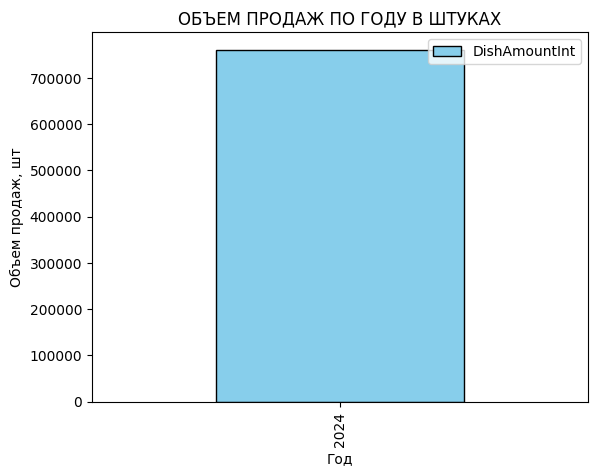

In [ ]:
# Графически изображаем силуэт продаж с отбором по временным критериям
# Годовое вырожение продаж
import matplotlib.pyplot as plt

# Группировка данных по годам
year = df.groupby('Year')['DishAmountInt'].sum().reset_index()

# Вывод гистограммы
year.plot(kind='bar', x='Year', y='DishAmountInt', color='skyblue', edgecolor='black')
plt.title('ОБЪЕМ ПРОДАЖ ПО ГОДУ В ШТУКАХ')
plt.xlabel('Год')
plt.ylabel('Объем продаж, шт')
plt.show()

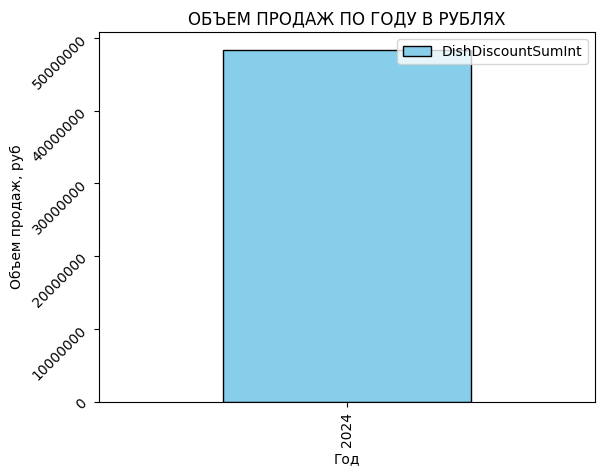

In [ ]:
# Группировка данных по годам
year = df.groupby('Year')['DishDiscountSumInt'].sum().reset_index()

# Вывод гистограммы
year.plot(kind='bar', x='Year', y='DishDiscountSumInt', color='skyblue', edgecolor='black')
plt.title('ОБЪЕМ ПРОДАЖ ПО ГОДУ В РУБЛЯХ')
plt.xlabel('Год')
plt.ylabel('Объем продаж, руб')

# Настройка формата меток на оси X
plt.tick_params(axis='y', which='both', labelsize=10, labelrotation=45)

# Отключение научной нотации
plt.ticklabel_format(axis='y', style='plain')
plt.show()

In [ ]:
months = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь',
          'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']

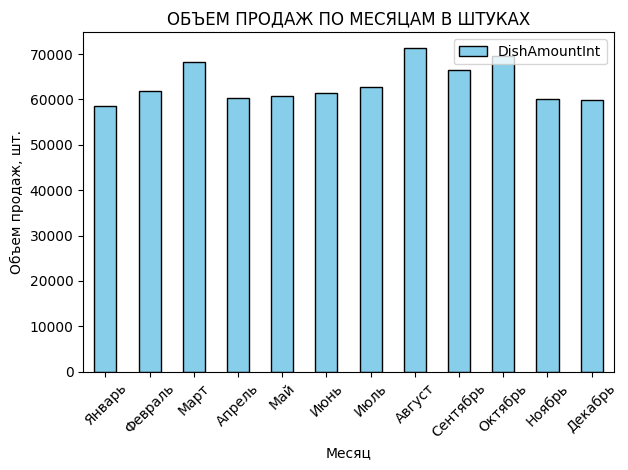

In [ ]:
# Группировка данных по месяцам
mon = df.groupby('Month')['DishAmountInt'].sum().reset_index()

# Вывод гистограммы
mon.plot(kind='bar', x='Month', y='DishAmountInt', color='skyblue', edgecolor='black')

# Настройка отображения
plt.title('ОБЪЕМ ПРОДАЖ ПО МЕСЯЦАМ В ШТУКАХ')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж, шт.')
plt.xticks(range(12), months, rotation=45)
plt.tight_layout()
plt.show()

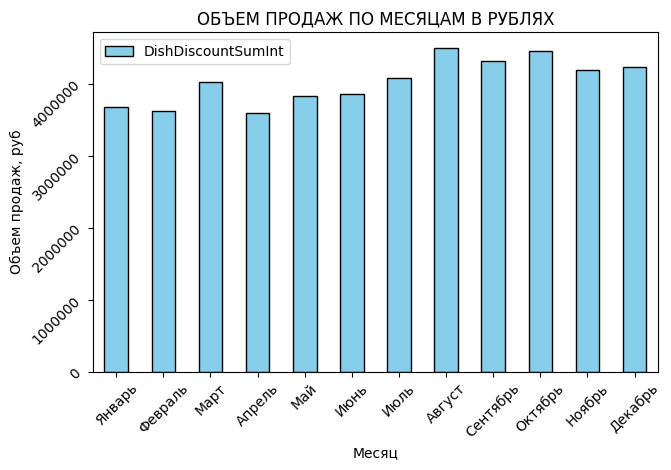

In [ ]:
# Группировка данных по месяцам
mon = df.groupby('Month')['DishDiscountSumInt'].sum().reset_index()

# Вывод гистограммы
mon.plot(kind='bar', x='Month', y='DishDiscountSumInt', color='skyblue', edgecolor='black')

# Настройка отображения
plt.title('ОБЪЕМ ПРОДАЖ ПО МЕСЯЦАМ В РУБЛЯХ')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж, руб')
plt.xticks(range(12), months, rotation=45)
plt.tight_layout()
# Настройка формата меток на оси X
plt.tick_params(axis='y', which='both', labelsize=10, labelrotation=45)

# Отключение научной нотации
plt.ticklabel_format(axis='y', style='plain')
plt.show()

In [ ]:
days_of_week = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

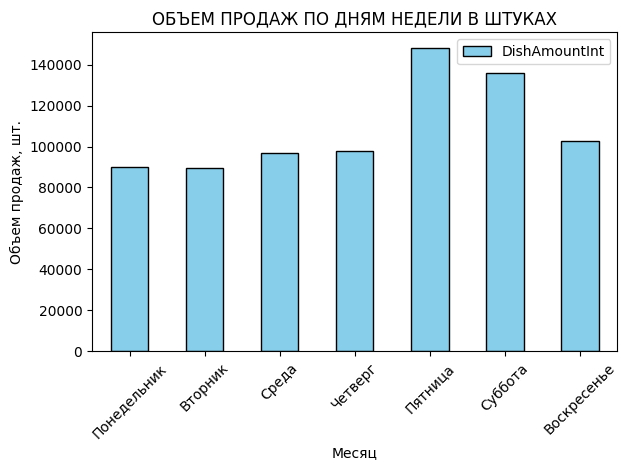

In [ ]:
# Группировка данных по дням недели
weekday = df.groupby('Weekday')['DishAmountInt'].sum().reset_index()

# Вывод гистограммы
weekday.plot(kind='bar', x='Weekday', y='DishAmountInt', color='skyblue', edgecolor='black')

# Настройка отображения
plt.title('ОБЪЕМ ПРОДАЖ ПО ДНЯМ НЕДЕЛИ В ШТУКАХ')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж, шт.')
plt.xticks(range(7), days_of_week, rotation=45)
plt.tight_layout()
plt.show()

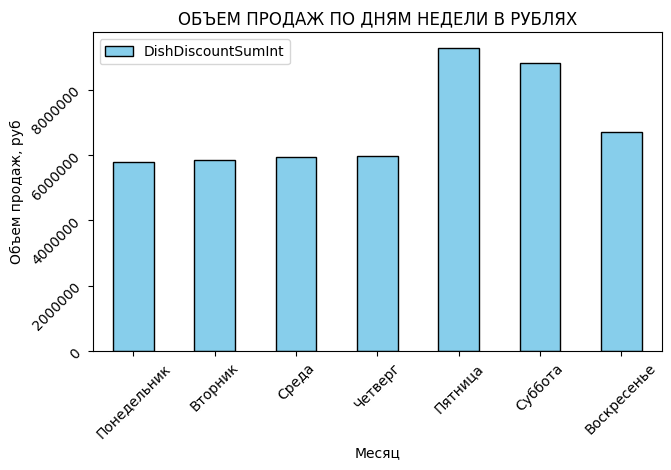

In [ ]:
# Группировка данных по дням недели
weekday = df.groupby('Weekday')['DishDiscountSumInt'].sum().reset_index()

# Вывод гистограммы
weekday.plot(kind='bar', x='Weekday', y='DishDiscountSumInt', color='skyblue', edgecolor='black')

# Настройка отображения
plt.title('ОБЪЕМ ПРОДАЖ ПО ДНЯМ НЕДЕЛИ В РУБЛЯХ')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж, руб')
plt.xticks(range(7), days_of_week, rotation=45)
plt.tight_layout()
# Настройка формата меток на оси X
plt.tick_params(axis='y', which='both', labelsize=10, labelrotation=45)

# Отключение научной нотации
plt.ticklabel_format(axis='y', style='plain')
plt.show()

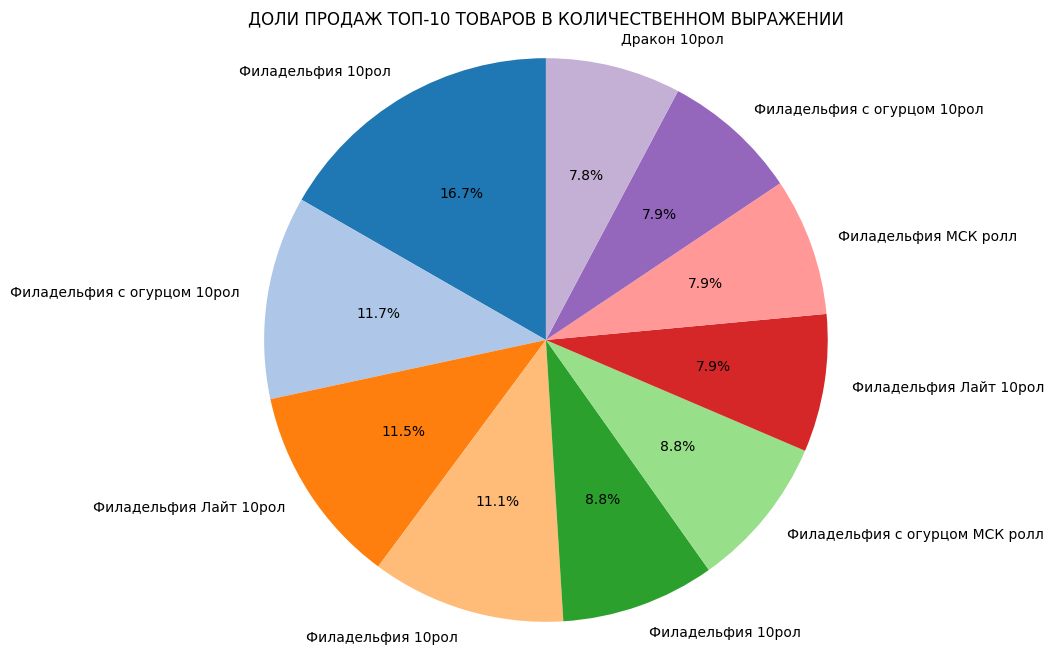

In [ ]:
# Доли продаж в штуках
df_top10 = df.sort_values(by='DishAmountInt', ascending=False).head(10)

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(df_top10['DishAmountInt'], labels=df_top10['DishName'], autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)

# Настройка отображения
plt.title('ДОЛИ ПРОДАЖ ТОП-10 ТОВАРОВ В КОЛИЧЕСТВЕННОМ ВЫРАЖЕНИИ')
plt.axis('equal')  # Чтобы диаграмма была круглой
plt.show()

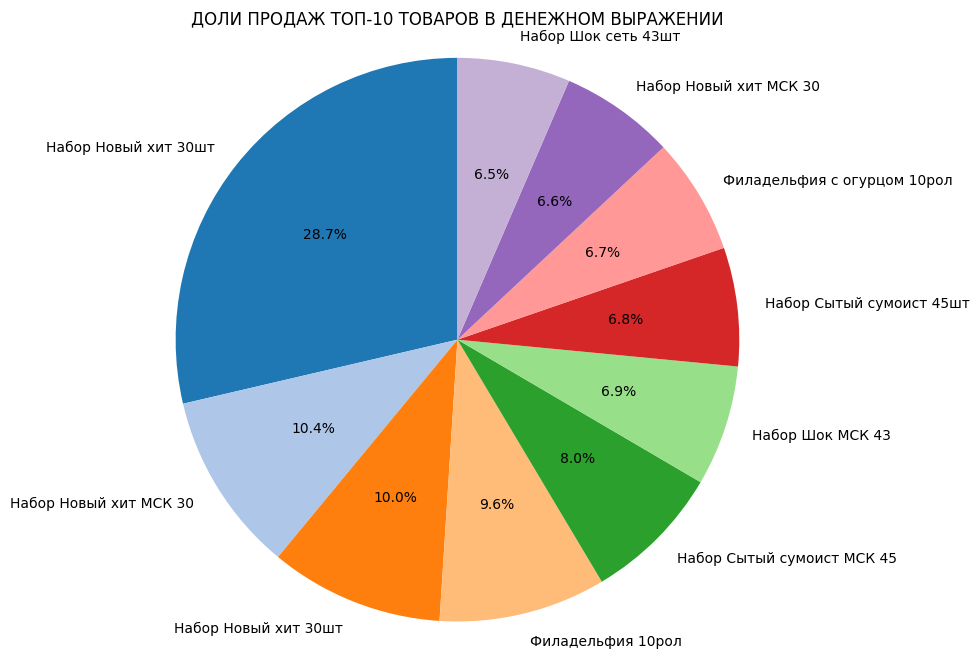

In [ ]:
# Доли продаж в рублях
df_top10 = df.sort_values(by='DishDiscountSumInt', ascending=False).head(10)

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(df_top10['DishDiscountSumInt'], labels=df_top10['DishName'], autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)

# Настройка отображения
plt.title('ДОЛИ ПРОДАЖ ТОП-10 ТОВАРОВ В ДЕНЕЖНОМ ВЫРАЖЕНИИ')
plt.axis('equal')  # Чтобы диаграмма была круглой
plt.show()

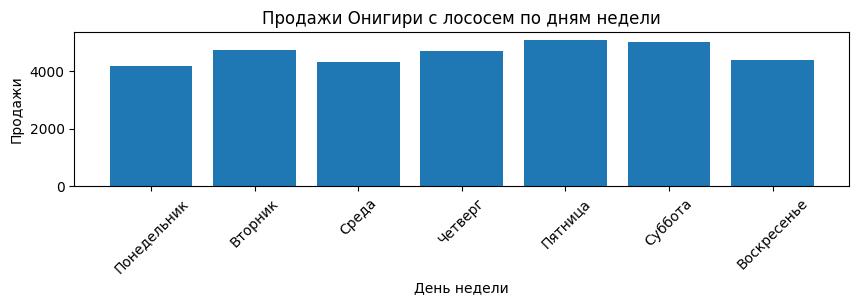

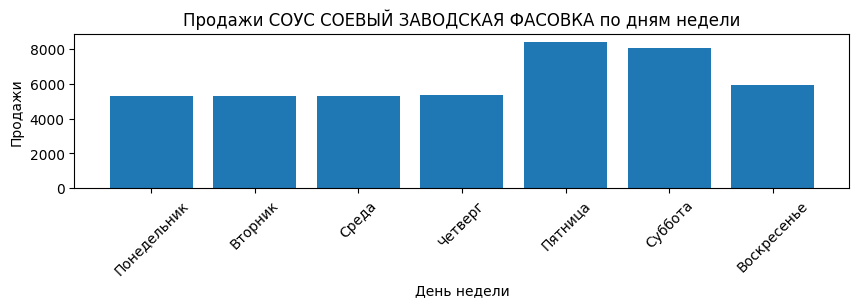

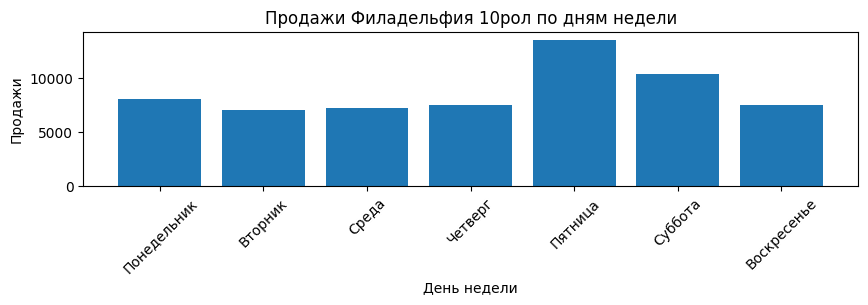

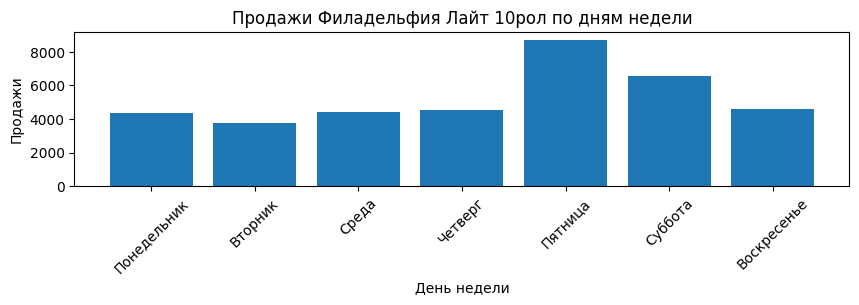

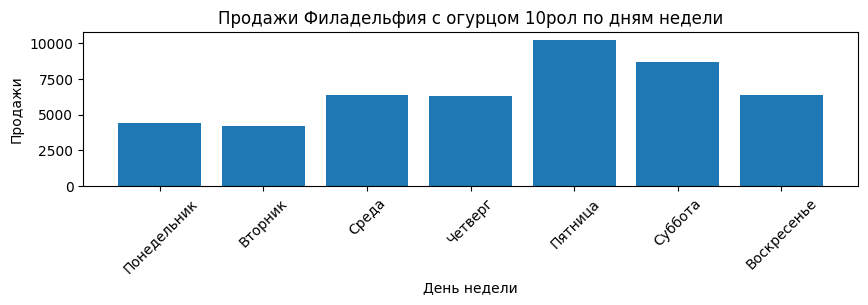

In [ ]:
# Характерный профиль продаж по каждой номенклатурной позиции, учитывая сезонность по дням недели
# Выбор топ-5 товаров по объему продаж
top5 = df.groupby('DishName')['DishAmountInt'].sum().nlargest(5).index
df_top5 = df[df['DishName'].isin(top5)]

# Агрегация данных по товару, дню недели и месяцу
df_agg = df_top5.groupby(['DishName', 'Weekday', 'Month'], as_index=False)['DishAmountInt'].sum()

# Визуализация профиля продаж
for товар in df_agg['DishName'].unique():
    df_tov = df_agg[df_agg['DishName'] == товар]

    # График по дням недели
    plt.figure(figsize=(10, 2))
    plt.bar(df_tov['Weekday'].unique(), df_tov.groupby('Weekday')['DishAmountInt'].sum())
    plt.title(f'Продажи {товар} по дням недели')
    plt.xticks(range(7), days_of_week, rotation=45)
    plt.xlabel('День недели')
    plt.ylabel('Продажи')
    plt.show()

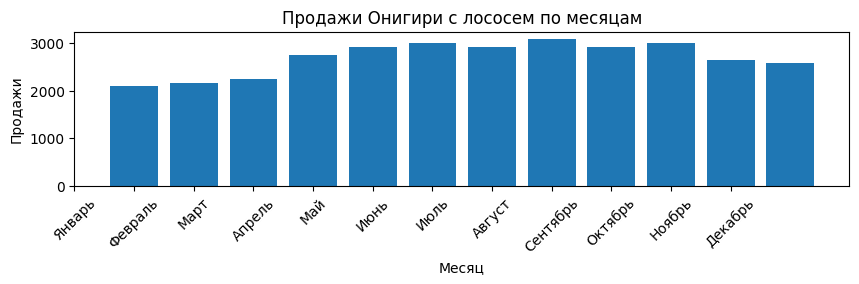

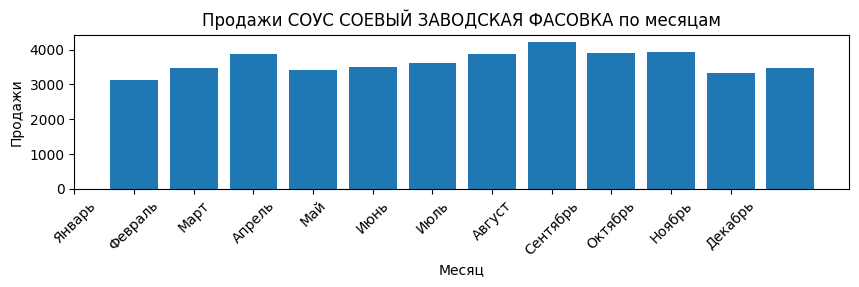

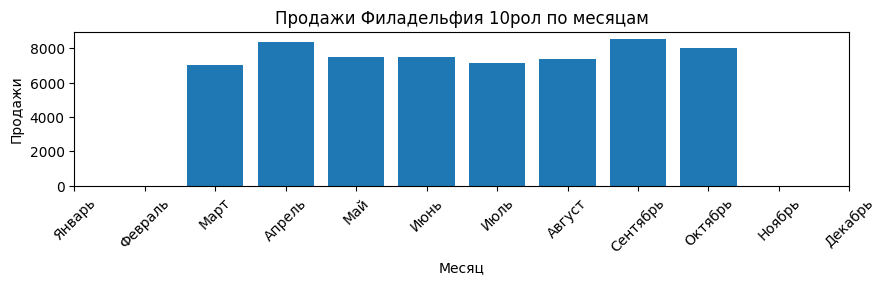

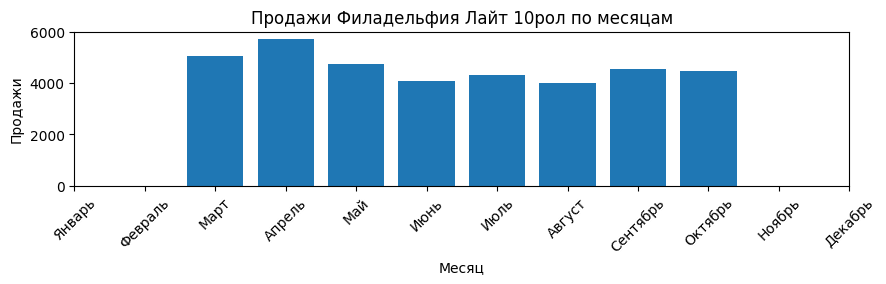

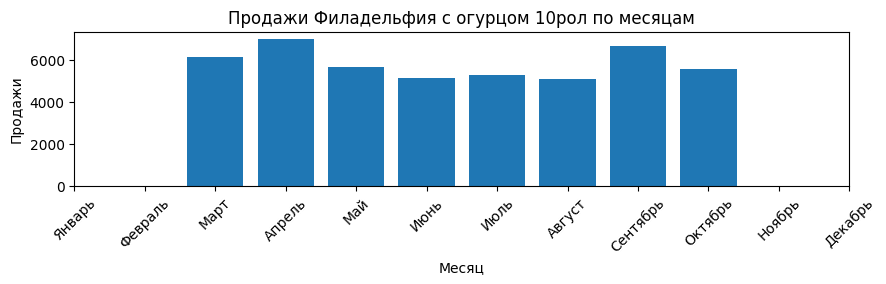

In [ ]:
# Визуализация профиля продаж
for товар in df_agg['DishName'].unique():
    df_tov = df_agg[df_agg['DishName'] == товар]

    # График по месяцам
    plt.figure(figsize=(10, 2))
    plt.bar(df_tov['Month'].unique(), df_tov.groupby('Month')['DishAmountInt'].sum())
    plt.title(f'Продажи {товар} по месяцам')
    plt.xticks(range(12), months, rotation=45)
    plt.xlabel('Месяц')
    plt.ylabel('Продажи')
    plt.show()

## **3.** ПРЕДВАРИТЕЛЬНЫЙ ПРОГНОЗ НА ЗАВТРАШНИЙ ДЕНЬ
> Развернуть


In [ ]:
from datetime import datetime, timedelta

# Определение завтрашней даты
tomorrow = datetime.now() + timedelta(days=1)
tomorrow_day_week = tomorrow.strftime('%A')     # Название дня недели
tomorrow_month = tomorrow.strftime('%B')        # Название месяца

# Прогноз продаж на завтра
prediction = {}

for product in df['DishName'].unique():
    df_product = df[df['DishName'] == product]

    # Фильтрация данных по дню недели и месяцу
    df_filter = df_product[(df_product['Weekday'] == tomorrow_day_week) & (df_product['Month'] == tomorrow_month)]

    # Прогноз как среднее значение продаж за аналогичные дни
    if not df_filter.empty:
        prediction[product] = df_filter['DishAmountInt'].mean()
    else:
        prediction[product] = df_product['DishAmountInt'].mean()  # Если данных нет, используем общее среднее

# Вывод прогноза
print("Прогноз продаж на завтра:")
for product, capacity in prediction.items():
    print(f"{product}: {round(capacity)}: ед.")

Прогноз продаж на завтра:
&Набор Калифорния подаро 8рол: 2: ед.
&Набор Калифорния подарок 8рол: 2: ед.
&Набор Популярный Дуэт 8рол: 1: ед.
&Набор Приведи друга Бостон 8рол: 1: ед.
&Онигири креветка подарок: 1: ед.
Rollbox Аппетитный 10шт: 1: ед.
Rollbox Любимый 10шт: 1: ед.
Rollbox Популярный 10шт: 1: ед.
Rollbox Суши Бокс 5шт: 1: ед.
Rollbox Филадельфия 10шт: 1: ед.
Rollbox Фитнес-Бокс 13шт: 1: ед.
Rollbox Фиш микс 10шт: 1: ед.
Амазонка запеч 10рол: 7: ед.
Амазонка запеч МСК: 6: ед.
Амазонка запеч ролл10: 8: ед.
Аризона 10 рол: 25: ед.
Аризона 10рол: 27: ед.
Аризона МСК ролл: 36: ед.
Бансай 10рол: 47: ед.
Бансай МСК ролл: 41: ед.
Бонито 10рол: 40: ед.
Бонито МСК ролл: 38: ед.
Бостон 10рол: 43: ед.
Бостон МСК ролл: 44: ед.
Босфор запеч 10рол: 8: ед.
Босфор запеч МСК: 9: ед.
ВАСАБИ ЗАВОДСКАЯ ФАСОВКА: 57: ед.
ВИЛОЧКА В УПАКОВКЕ ОДНОР: 6: ед.
ВИЛОЧКА ОДНОР: 5: ед.
ВОДА Б/Г 0,33л: 2: ед.
ВОДА Б/Г СУШИ - МАРКЕТ 0,33л: 2: ед.
ВОДА В АССОРТ 0,5 л: 1: ед.
Валенсия МСК ролл: 54: ед.
Вок с бекон

## **4.** ПРОГНОЗ НА ИНСТРУМЕНТАХ ML
> Развернуть

In [ ]:
df.head(3)

,DishName,OpenDate_Typed,DishAmountInt,DishDiscountSumInt,Year,Month,Week,Weekday
0,&Набор Калифорния подаро 8рол,2024-02-01,3,3,2024,2,5,3
1,&Набор Калифорния подаро 8рол,2024-02-02,1,1,2024,2,5,4
2,&Набор Калифорния подаро 8рол,2024-02-03,3,3,2024,2,5,5


In [ ]:
# Подготовим датафрейм для обучения
# Добавим в датафейм новые признаки - "holiday" и "friday"
import holidays

# Добавление праздничных дней РФ
ru_holidays = holidays.Russia()

# Добавление столбца с праздничными днями
df['holiday'] = df['OpenDate_Typed'].apply(lambda x: x in ru_holidays)

# Добавление столбца "пятница"
df['friday'] = df['OpenDate_Typed'].dt.dayofweek == 5

In [ ]:
df.tail(3)

,DishName,OpenDate_Typed,DishAmountInt,DishDiscountSumInt,Year,Month,Week,Weekday,holiday,friday
22676,Ясай 10рол,2024-12-29,15,330,2024,12,52,6,False,False
22677,Ясай 10рол,2024-12-30,10,220,2024,12,1,0,True,False
22678,Ясай 10рол,2024-12-31,2,44,2024,12,1,1,True,False


In [ ]:
# Определяем категорийные признаки для CatBoost
cat_list = ['DishName']

In [ ]:
# Удаляем из датафрейма признаки, которые не влияют на обучение модели ('Year', 'OpenDate_Typed')
df = df.drop(columns=['Year', 'OpenDate_Typed', 'DishDiscountSumInt'])

In [ ]:
# Для увеличения обобщающей способности модели перемешаем данные в датафрейме
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,DishName,DishAmountInt,Month,Week,Weekday,holiday,friday
0,Темпура Перу 10ролл,10,6,26,4,False,False
1,ВИЛОЧКА В УПАКОВКЕ ОДНОР,3,7,30,3,False,False
2,Трайфл с крабом (имитация) 1шт,5,10,41,4,False,False
3,Аризона 10рол,33,4,16,3,False,False
4,Набор Сытый сумоист 45шт,4,5,20,1,False,False
5,Москва10рол,20,7,29,0,False,False
6,Дракон лайт МСК ролл,40,1,1,5,True,True
7,Калифорния люкс 10рол,79,3,9,5,False,True
8,Темпура Филадельфия 10ролл,10,6,26,3,False,False
9,Дракон 10рол,59,4,17,0,False,False


In [ ]:
from sklearn.model_selection import train_test_split

# Отбрасываем целевое значение и данные для обучения, сохраняем в 2 переменные
X = df.drop('DishAmountInt', axis=1)
y = df['DishAmountInt']

# Разделение на обучающую (80%) и временную (20%) выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Решение на CatBoost

In [ ]:
# Устанавливаем библиотеку для градиентного бустинга на деревьях
%%capture
!pip install catboost

In [ ]:
# Создаем модель CatBoost и настраиваем гиперпараметры
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=9000,            # Количество итераций (деревьев)
                          learning_rate=0.1,          # Скорость обучения
                          depth=15,                   # Глубина деревьев
                          verbose=300,                # Периодичность вывода логов
                          early_stopping_rounds=50,   # Ранняя остановка, если нет улучшений качества
                          loss_function='RMSE',       # Функция ошибки
                          cat_features=cat_list)      # Список категорийных признаков

In [ ]:
# Запуск обучения
model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 49.2338165	test: 48.6024142	best: 48.6024142 (0)	total: 82ms	remaining: 12m 17s
300:	learn: 13.3161283	test: 15.8164413	best: 15.8164413 (300)	total: 1m 26s	remaining: 41m 27s
600:	learn: 9.5353347	test: 15.0456654	best: 15.0445809 (596)	total: 2m 40s	remaining: 37m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 14.92249399
bestIteration = 687

Shrink model to first 688 iterations.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Делаем предсказания
y_pred = model.predict(X_test)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Оцениваем качество модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")      # Корень из cреднего значения квадратов разностей между предсказанными и фактическими значениями
print(f"MSE: {mse:.3f}")        # Среднее значение квадратов разностей между предсказанными и фактическими значениями
print(f"MAE: {mae:.3f}")        # Среднее значение абсолютных разностей между предсказанными и фактическими значениями
print(f"MAPE: {mape:.2f}%")     # MAPE показывает среднюю процентную ошибку предсказаний (чем меньше MAPE, тем лучше)
print(f"R²: {r2:.3f}")          # Коэффициент детерминации. Насколько хорошо модель объясняет дисперсию данных (чем ближе к 1, тем лучше)

RMSE: 14.922
MSE: 222.681
MAE: 7.971
MAPE: 52.33%
R²: 0.915


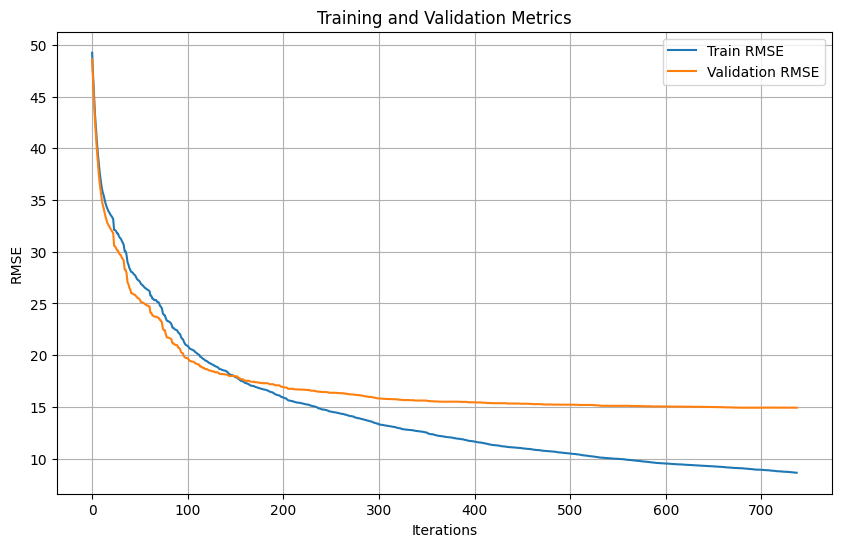

In [ ]:
# Получаем историю обучения
history = model.get_evals_result()

# Извлекаем метрики
train_metrics = history['learn']['RMSE']
valid_metrics = history['validation']['RMSE']

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(train_metrics, label='Train RMSE')
plt.plot(valid_metrics, label='Validation RMSE')
plt.xlabel('Итерации')
plt.ylabel('RMSE')
plt.title('Метрики обучения и проверки')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Сохраняем обученную модель в файл
import joblib
from catboost import CatBoostRegressor

# Сохраняем модель с помощью joblib
joblib.dump(model, 'catboost_regressor.joblib')

['catboost_regressor.joblib']

In [ ]:
# Загружаем модель
loaded_model = joblib.load('catboost_regressor.joblib')

In [ ]:
# Изучм характеристики сохраненной модели
feature_names = loaded_model.feature_names_
print(f"Имена признаков, которые ожидает модель на инференсе: {feature_names}", '\n')
params = loaded_model.get_params()
print(f"Параметры при обучении модели: {params}")

Имена признаков, которые ожидает модель на инференсе: ['DishName', 'Month', 'Week', 'Weekday', 'holiday', 'friday'] 

Параметры при обучении модели: {'iterations': 9000, 'learning_rate': 0.1, 'depth': 15, 'loss_function': 'RMSE', 'verbose': 300, 'early_stopping_rounds': 50, 'cat_features': ['DishName']}


In [ ]:
# Функция определения завтрашней даты
tomorrow_list = []

def get_tomorrow_info():
    today = datetime.now()                                  # Определяем сегодняшний день
    tomorrow = today + timedelta(days=1)                    # Добавляем один день к текущей дате

    month_number = tomorrow.month - 1                       # Номер месяца (январь - 0, декабрь - 11)
    tomorrow_list.append(month_number)

    week_number = tomorrow.isocalendar()[1] - 1             # Номер недели в году (первая неделя - 0)
    tomorrow_list.append(week_number)

    day_of_week = tomorrow.weekday()                        # Номер дня недели (понедельник - 0, воскресенье - 6)
    tomorrow_list.append(day_of_week)

    friday = True if tomorrow.weekday() == 4 else False     # Определяение пятницы
    tomorrow_list.append(friday)

    is_holiday = tomorrow in ru_holidays                    # Определяение праздника
    tomorrow_list.append(is_holiday)

get_tomorrow_info()
print(tomorrow_list)

[2, 10, 6, False, False]


In [ ]:
# Функция перебора всех товаров и создания прогноза
dictionary_pred = {}

def sushi_predict():
    for i in unique_values:
        result_predict = loaded_model.predict([i, *tomorrow_list])
        dictionary_pred[i] = round(result_predict)

sushi_predict()
print(len(unique_values))
print(dictionary_pred)

172
{'&Набор Калифорния подаро 8рол': 1, '&Набор Калифорния подарок 8рол': 1, '&Набор Популярный Дуэт 8рол': 2, '&Набор Приведи друга Бостон 8рол': 2, '&Онигири креветка подарок': 4, 'Rollbox Аппетитный 10шт': 2, 'Rollbox Любимый 10шт': 1, 'Rollbox Популярный 10шт': 1, 'Rollbox Суши Бокс 5шт': 4, 'Rollbox Филадельфия 10шт': 1, 'Rollbox Фитнес-Бокс 13шт': 4, 'Rollbox Фиш микс 10шт': 1, 'Амазонка запеч 10рол': 1, 'Амазонка запеч МСК': 1, 'Амазонка запеч ролл10': 8, 'Аризона 10 рол': 13, 'Аризона 10рол': 6, 'Аризона МСК ролл': 22, 'Бансай 10рол': 31, 'Бансай МСК ролл': 24, 'Бонито 10рол': 28, 'Бонито МСК ролл': 21, 'Бостон 10рол': 27, 'Бостон МСК ролл': 46, 'Босфор запеч 10рол': 5, 'Босфор запеч МСК': 2, 'ВАСАБИ ЗАВОДСКАЯ ФАСОВКА': 32, 'ВИЛОЧКА В УПАКОВКЕ ОДНОР': 2, 'ВИЛОЧКА ОДНОР': 5, 'ВОДА Б/Г 0,33л': 1, 'ВОДА Б/Г СУШИ - МАРКЕТ 0,33л': 1, 'ВОДА В АССОРТ 0,5 л': 4, 'Валенсия МСК ролл': 51, 'Вок с беконом в сливочном соусе 330гр': 2, 'Вок с беконом в терияки соусе 330гр': 1, 'Вок с кревет

In [ ]:
# Сохранение результатов в Excel
df = pd.DataFrame({'Наименование': dictionary_pred.keys(), 'Количество, шт.': dictionary_pred.values()})

df.to_excel('./Sushi_ML_pred.xlsx', sheet_name='Budgets', index=False)

## **5.** ОБНОВЛЕНИЕ С УЧЕТОМ Time Series
> Развернуть

In [5]:
df.head(3)

,CloseTime,DishAmountInt,DishDiscountSumInt,DishName,RestorauntGroup,OpenDate.Typed
0,2025-02-08 17:16:49,6,228,Лава МСК рол,"Омск, АТ-Маркет, Дианова, 14",2025-02-08
1,2025-02-08 10:17:08,1,5,ПАКЕТ МАЙКА ОДНОР,"Омск, АТ-Маркет, Дианова, 14",2025-02-08
2,2025-02-08 10:17:08,1,25,Контейнер большой одн,"Омск, АТ-Маркет, Дианова, 14",2025-02-08


In [6]:
df = df.drop(columns=['CloseTime', 'RestorauntGroup', 'DishDiscountSumInt', 'RestorauntGroup'])

In [7]:
df

,DishAmountInt,DishName,OpenDate.Typed
0,6,Лава МСК рол,2025-02-08
1,1,ПАКЕТ МАЙКА ОДНОР,2025-02-08
2,1,Контейнер большой одн,2025-02-08
3,2,ВАСАБИ ЗАВОДСКАЯ ФАСОВКА,2025-02-08
4,3,СОУС СОЕВЫЙ ЗАВОДСКАЯ ФАСОВКА,2025-02-08
...,...,...,...
326614,2,ВАСАБИ ЗАВОДСКАЯ ФАСОВКА,2025-02-28
326615,5,Калифорния акция МСК 10ролл,2025-02-28
326616,5,Филадельфия МСК ролл,2025-02-28
326617,1,ПАКЕТ МАЙКА ОДНОР,2025-02-28


In [10]:
#df = df.groupby(['DishName', 'OpenDate.Typed']).agg({'DishAmountInt': 'sum'}).reset_index()

In [8]:
df.set_index('OpenDate.Typed', inplace = True)

In [9]:
df.index = pd.to_datetime(df.index)

In [10]:
df

,DishAmountInt,DishName
OpenDate.Typed,,
2025-02-08,6,Лава МСК рол
2025-02-08,1,ПАКЕТ МАЙКА ОДНОР
2025-02-08,1,Контейнер большой одн
2025-02-08,2,ВАСАБИ ЗАВОДСКАЯ ФАСОВКА
2025-02-08,3,СОУС СОЕВЫЙ ЗАВОДСКАЯ ФАСОВКА
...,...,...
2025-02-28,2,ВАСАБИ ЗАВОДСКАЯ ФАСОВКА
2025-02-28,5,Калифорния акция МСК 10ролл
2025-02-28,5,Филадельфия МСК ролл


[Text(0.5, 1.0, 'ГРАФИК ПРОДАЖ'),
 Text(0.5, 0, 'ДАТА'),
 Text(0, 0.5, 'КОЛИЧЕСТВО')]

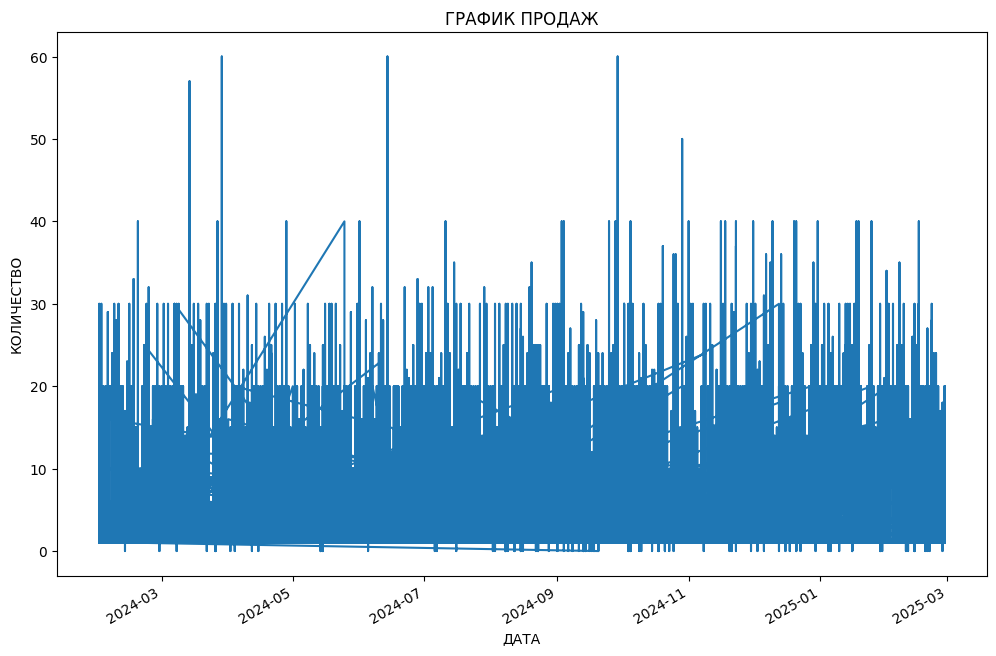

In [11]:
import matplotlib.pyplot as plt
ax = df.plot(figsize = (12,8), legend = None)
ax.set(title = 'ГРАФИК ПРОДАЖ', xlabel = 'ДАТА', ylabel = 'КОЛИЧЕСТВО')

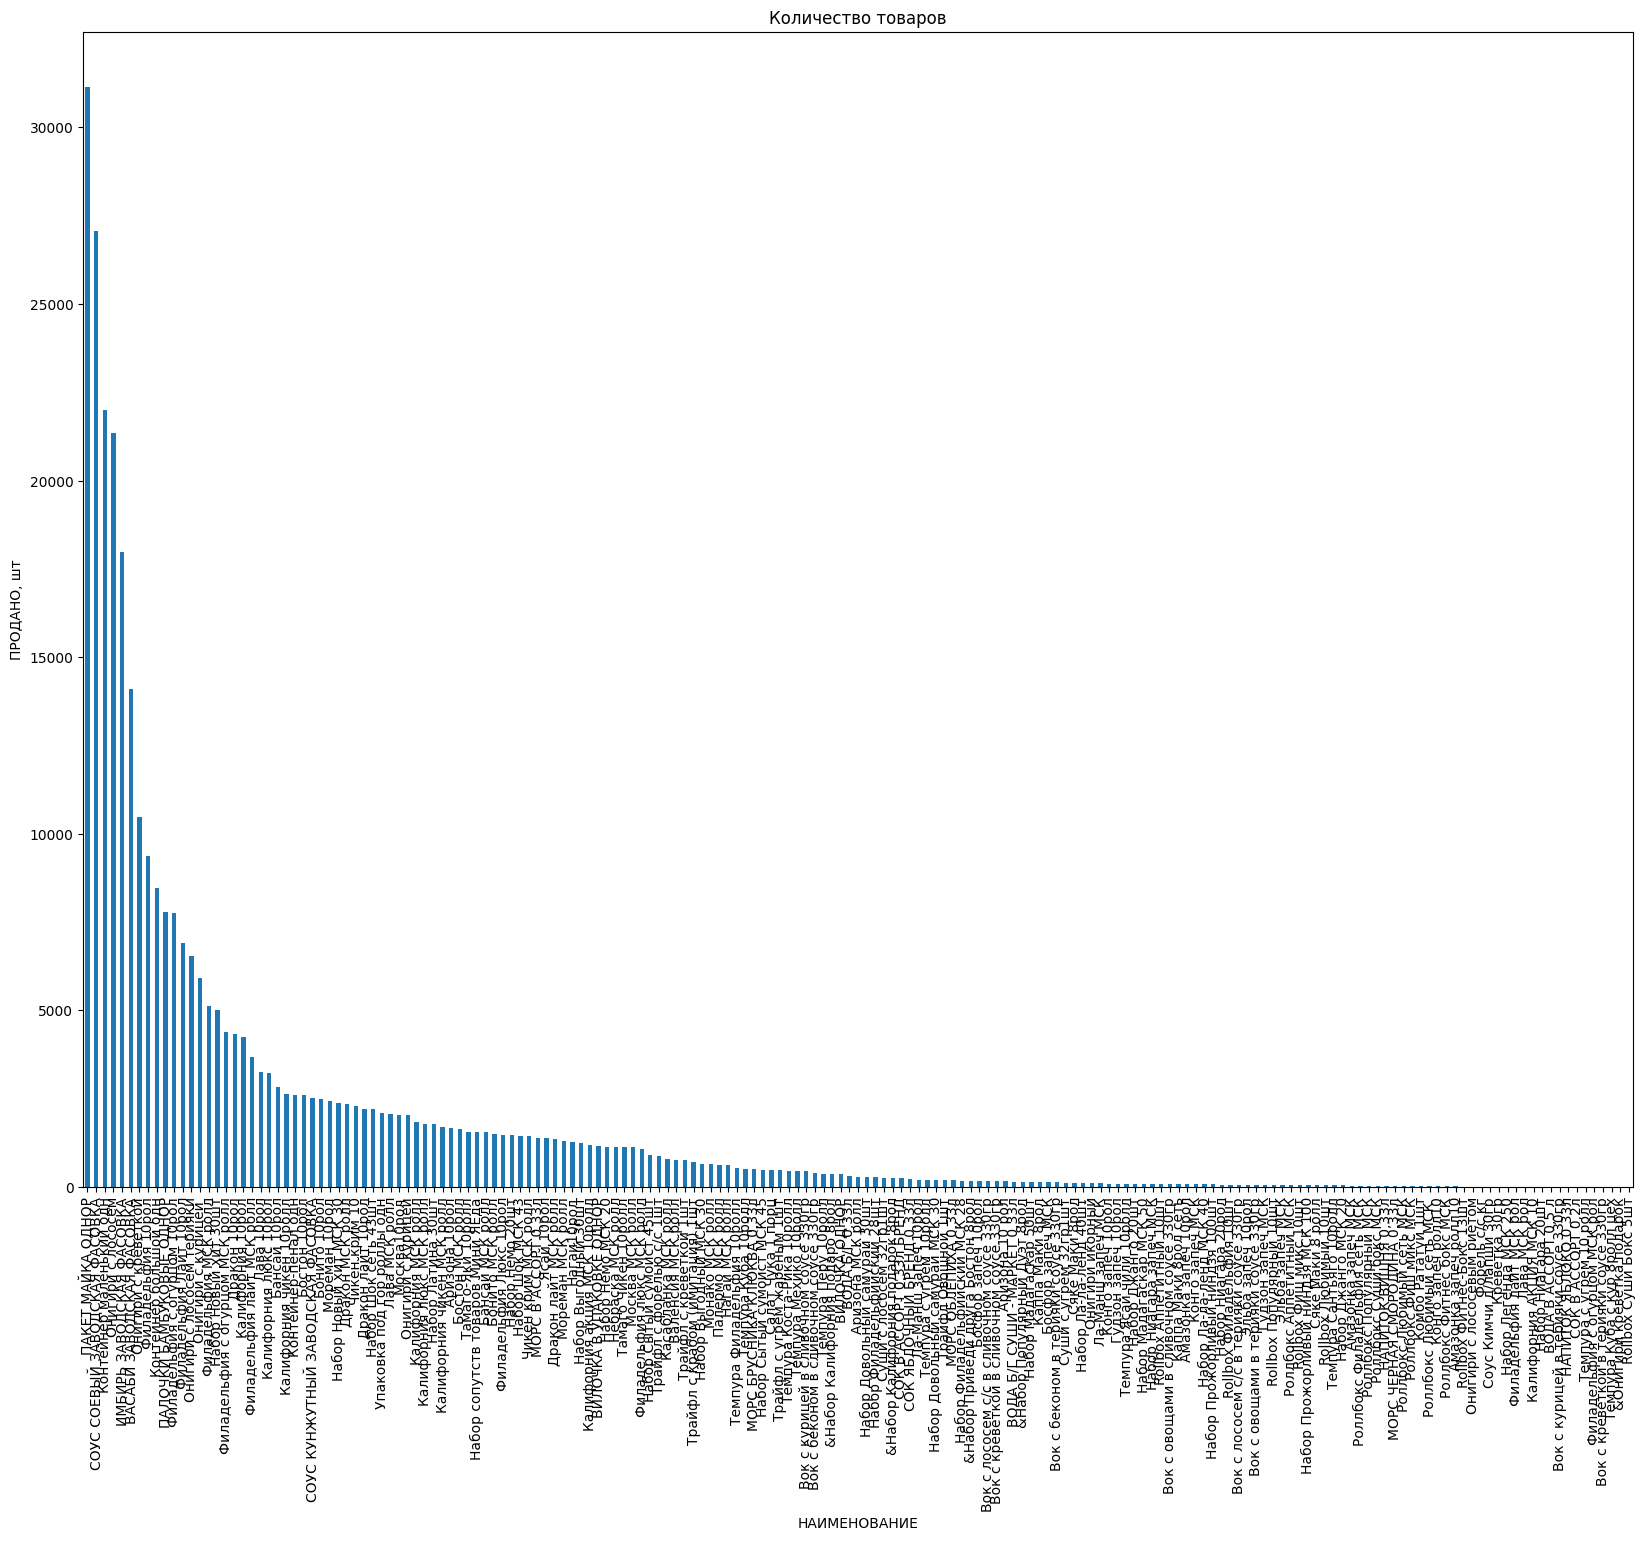

In [30]:
# Строим график количества товаров
df['DishName'].value_counts().plot(kind='bar', figsize=(20, 15))
plt.title('Количество товаров')
plt.xlabel('НАИМЕНОВАНИЕ')
plt.ylabel('ПРОДАНО, шт')
plt.show()

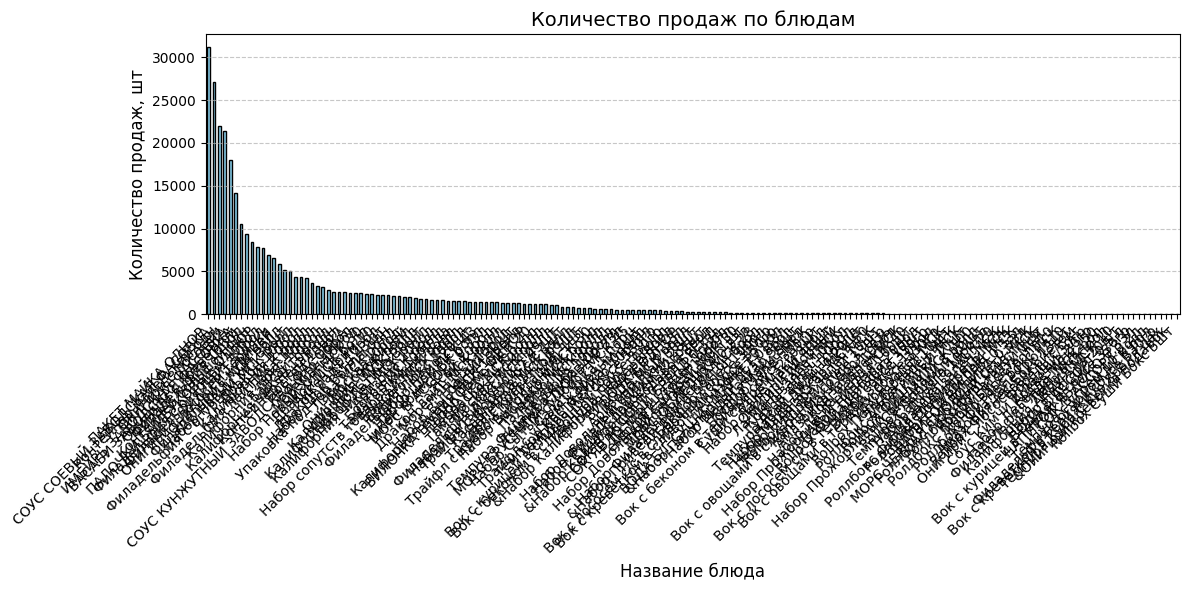

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Подсчитываем количество каждого блюда
dish_counts = df['DishName'].value_counts()

# Строим график с настройками
plt.figure(figsize=(12, 6))  # Задаём размер графика (ширина, высота в дюймах)

# Рисуем столбчатую диаграмму
dish_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Настройки оформления
plt.title('Количество продаж по блюдам', fontsize=14)
plt.xlabel('Название блюда', fontsize=12)
plt.ylabel('Количество продаж, шт', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Наклон подписей для читаемости
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Сетка только по оси Y

# Автоматическая подгонка layout, чтобы подписи не обрезались
plt.tight_layout()
plt.show()

In [32]:
sales_by_date = df.groupby('OpenDate.Typed').size().reset_index(name='DishAmountInt')

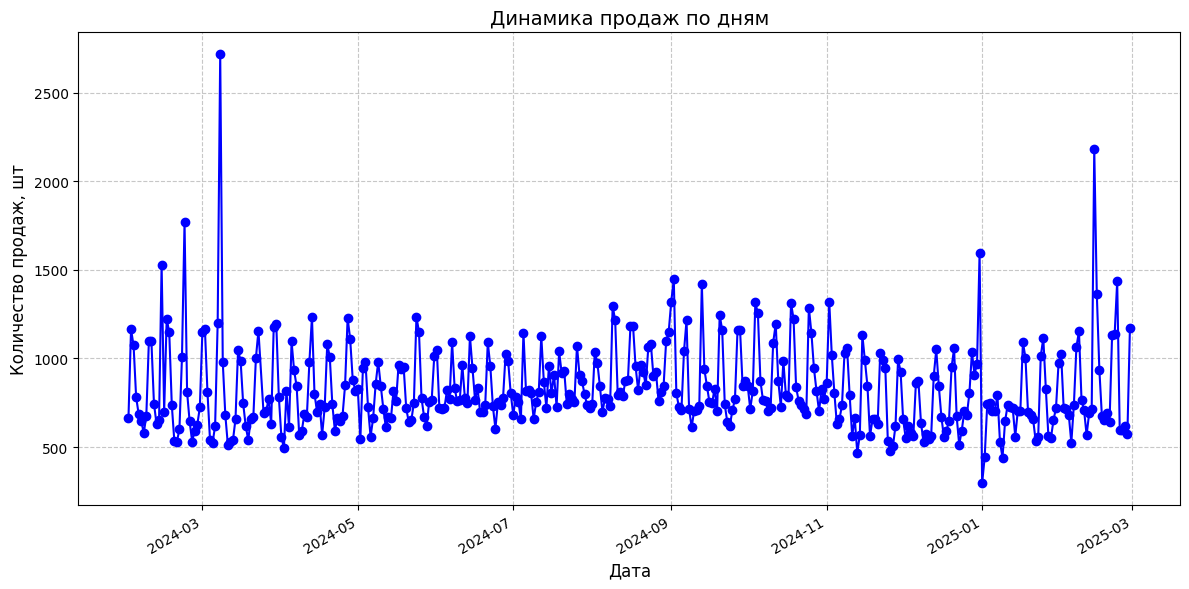

In [33]:
plt.figure(figsize=(12, 6))

# Линейный график продаж по дате
plt.plot(sales_by_date['OpenDate.Typed'], sales_by_date['DishAmountInt'],
         marker='o', linestyle='-', color='blue')

# Настройки оформления
plt.title('Динамика продаж по дням', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество продаж, шт', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Форматирование даты на оси X
plt.gcf().autofmt_xdate()  # Автоматический поворот дат

plt.tight_layout()
plt.show()

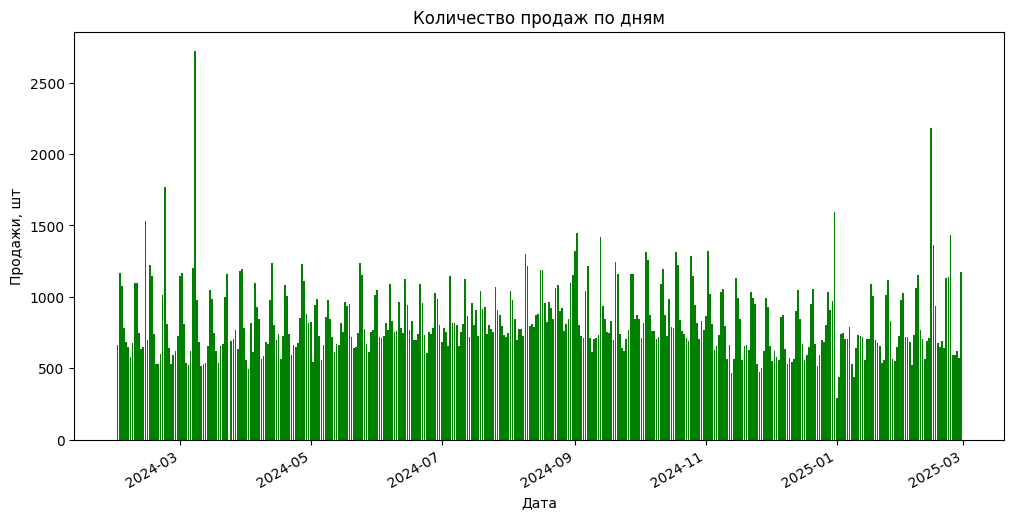

In [35]:
plt.figure(figsize=(12, 6))
plt.bar(sales_by_date['OpenDate.Typed'], sales_by_date['DishAmountInt'], color='green')
plt.title('Количество продаж по дням')
plt.xlabel('Дата')
plt.ylabel('Продажи, шт')
plt.gcf().autofmt_xdate()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


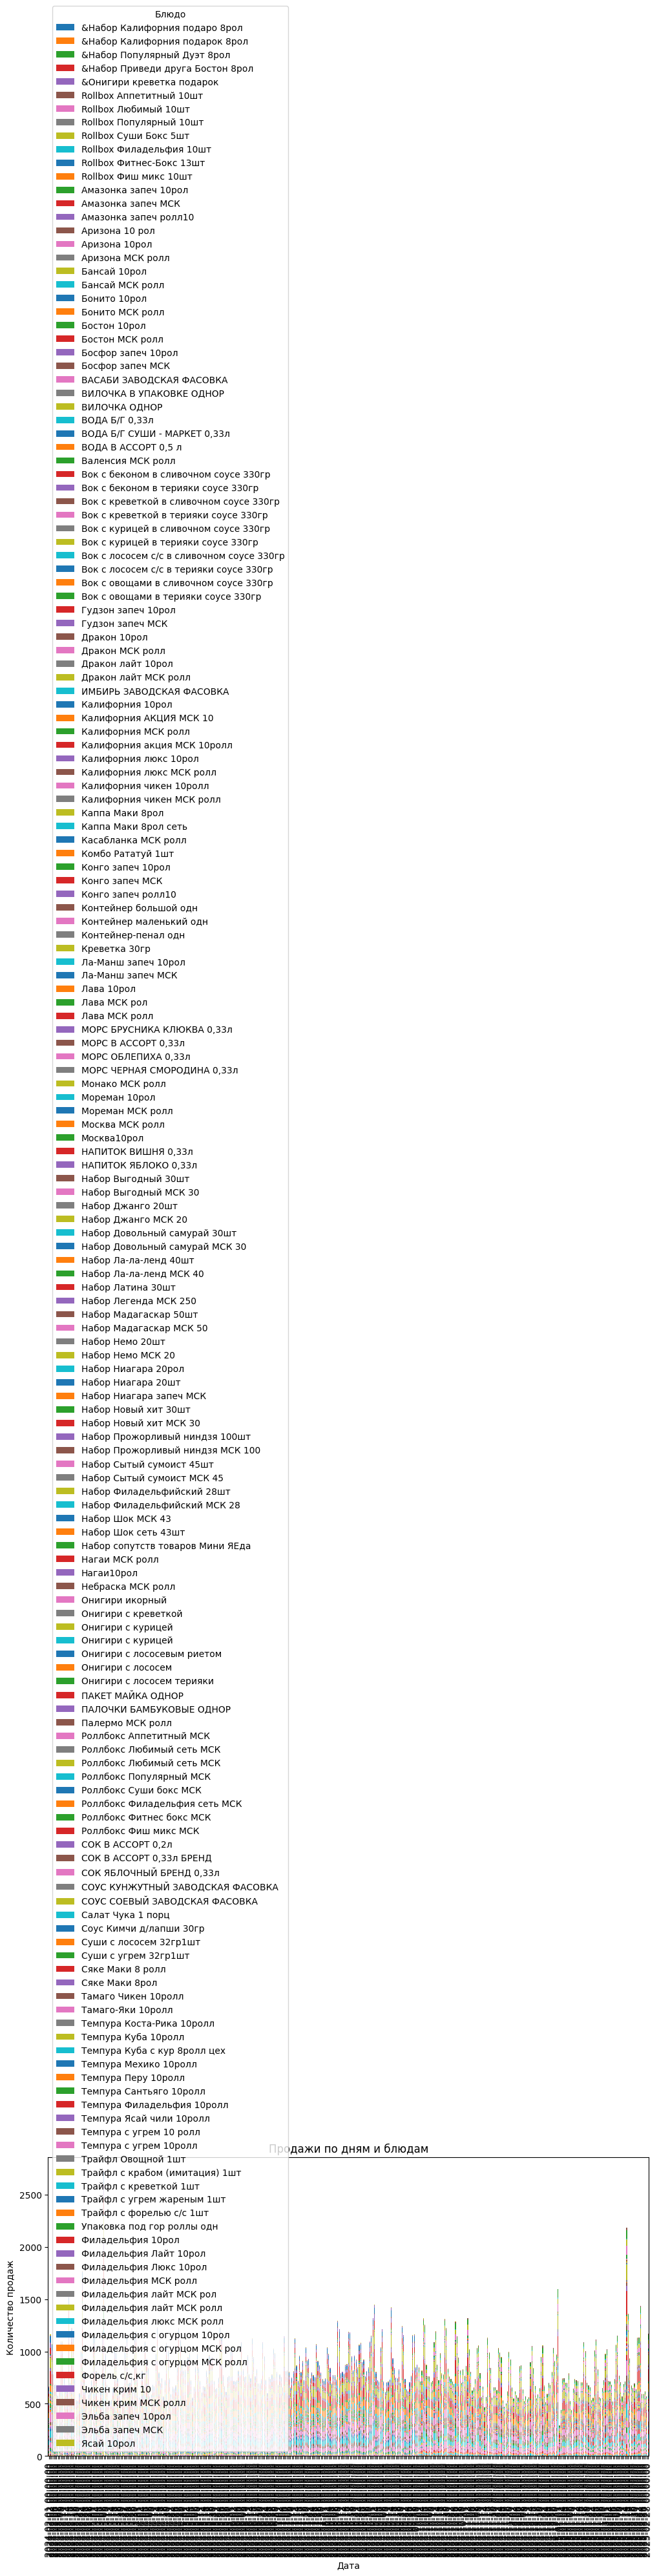

In [36]:
# Группируем по дате и названию блюда
sales_by_date_dish = df.groupby(['OpenDate.Typed', 'DishName']).size().unstack()

# Строим stacked bar chart
sales_by_date_dish.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Продажи по дням и блюдам')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')
plt.legend(title='Блюдо')
plt.show()